In [1]:
import datetime
import numpy as np
import pandas as pd
import os.path as osp

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import os
import os.path as osp
df_file = pd.read_csv('新北京路区精细化日表mk1.csv', encoding='gbk')
# df.to_csv('../效能服务质量/460137_1.csv', index=False, encoding='gbk')

In [3]:
leixing = ['', '工业区', 'CBD', '住宅区', '专业市场', '商住混合区(偏住)', '商住混合区(偏商)', '学校医院等大型机构', '乡镇', '商业区']

In [4]:
cat_cols = ['日期', '星期几', '营业部', '路区号', '路区面积', '路区类型', '路区距离']
num_cols = ['路区面积', '妥投单量', '揽收单量', '路区效能', '路区到站妥投及时率', '路区C端首揽及时率', '路区全量服务投诉量']
# second_cols = ['妥投密度', '揽收密度', '妥投×面积', '揽收×面积']

In [5]:
df_file = df_file.rename(columns={'road_distance':'路区距离', '揽件单量':'揽收单量','rq':'日期', 'sta_id':'营业部', 'road_code':'路区号', 'road_area':'路区面积', 'roadarea_type':'路区类型'})
df_file.head()

,日期,营业部,路区号,路区面积,路区类型,路区距离,妥投单量,B端揽收单量,C端揽收单量,路区到站妥投及时率,路区C端首揽及时率,路区C端催揽收量,路区B端催揽收量,路区全量服务投诉量,揽收单量,date,weekday
0,2021-10-21,284764,6,0.37,3,1.10,218,12,25,0.9548,0.0,0.0,0.0,0.0,24,2021-10-21,3
1,2021-10-21,474899,18,0.12,6,0.10,177,3,4,0.9494,1.0,0.0,0.0,0.0,6,2021-10-21,3
2,2021-10-21,474899,26,0.13,6,0.39,118,10,5,0.9492,1.0,0.0,0.0,0.0,20,2021-10-21,3
3,2021-10-21,474899,16,0.22,6,1.11,177,8,13,0.9389,1.0,0.0,0.0,0.0,16,2021-10-21,3
4,2021-10-21,474899,9,0.14,5,0.22,106,3,1,0.8919,1.0,0.0,0.0,0.0,6,2021-10-21,3


In [6]:
df = df_file.copy()
df['营业部路区'] = [str(df.营业部.iloc[i])+'|'+str(df.路区号.iloc[i]) for i in range(len(df))]
df['路区效能'] = df['揽收单量'] + df['妥投单量']

# df['妥投密度'] = df['妥投单量'] / df['路区面积']
# df['揽收密度'] = df['揽收单量'] / df['路区面积']
# df['妥投×面积'] = df['妥投单量'] * df['路区面积']
# df['揽收×面积'] = df['揽收单量'] * df['路区面积']

# df['日期'] = df['日期'].map(lambda x: datetime.datetime.strptime(x, '%Y/%m/%d'))
df = df.sort_values(['营业部', '路区号','日期']).reset_index(drop=True)

In [7]:
# df.路区类型 = df.路区类型.map(lambda x: str(x)+':'+leixing[int(x)])
df['妥投能力'] = df['妥投单量'] * df['路区到站妥投及时率']

In [8]:
diff_area = 0.01
changes_index = []
change = []
changes = []
df['阶段'] = [0 for _ in range(len(df))]
for i, (di, df_x) in enumerate(df.groupby(['营业部路区'])['路区面积']):
    if len(df_x.unique()) > 1:
        st_idx = df_x.index[0]
        df_tmp = pd.DataFrame(df_x).diff().iloc[1:]
        diff_index = df_tmp[(df_tmp.路区面积 > diff_area) | (df_tmp.路区面积 < -diff_area)].index
        if len(diff_index) == 0: continue
        for ix, x in enumerate(diff_index):
            if ix == 0:
                df['阶段'].loc[st_idx:x] = [ix] * len(df['阶段'].loc[st_idx:x])
            else:
                df['阶段'].loc[pre:x] = [ix] * len(df['阶段'].loc[pre:x])
            pre = x
        df['阶段'].loc[pre:] = [ix+1] * len(df['阶段'].loc[pre:])
#         tmp = [df.营业部路区.iloc[df_index[0]], diff_index, df_x.index]
        changes.extend(df_x.index)
        changes_index.extend(diff_index)
df_changes = df.iloc[changes]
df_changes_index = df.iloc[changes_index]

In [9]:
# 统计各个路区的工作量
df_x = df.groupby(['营业部路区'])[['路区距离']+num_cols].mean()
df_x['营业部'] = df_x.index.map(lambda x: x.split('|')[0])
df_x['路区'] = df_x.index.map(lambda x: x.split('|')[1])
df_x

,路区距离,路区面积,妥投单量,揽收单量,路区效能,路区到站妥投及时率,路区C端首揽及时率,路区全量服务投诉量,营业部,路区
营业部路区,,,,,,,,,,
284764|1,1.330000,0.060000,216.619048,16.761905,233.380952,0.959908,0.163841,0.019048,284764,1
284764|10,0.330000,4.316604,300.566038,1070.018868,1370.584906,0.896263,0.117139,0.066038,284764,10
284764|11,1.830000,0.060000,128.032967,6.791209,134.824176,0.928829,0.133601,0.065934,284764,11
284764|12,1.690000,0.370000,176.252427,12.660194,188.912621,0.955111,0.135044,0.019417,284764,12
284764|13,1.185000,0.788750,329.596154,14.730769,344.326923,0.910450,0.118337,0.048077,284764,13
...,...,...,...,...,...,...,...,...,...,...
474899|5,1.058800,0.130000,161.600000,14.100000,175.700000,0.841423,0.930151,0.040000,474899,5
474899|6,0.853953,0.060000,136.511628,6.046512,142.558140,0.954126,0.954265,0.000000,474899,6
474899|7,0.739717,0.153396,248.509434,16.603774,265.113208,0.926157,0.918770,0.037736,474899,7


In [10]:
df_riqi = pd.DataFrame(columns=['日期', '营业部', '妥投单量_mean', '揽收单量_mean', '路区效能_mean'])

for i, (did, df_gp) in enumerate(df.groupby(['营业部', '日期'])):
#     if i > 0: break
    df_riqi.loc[len(df_riqi)] = [df_gp.日期.iloc[0], df_gp.营业部.iloc[0]] + df_gp.describe().loc['mean',['妥投单量', '揽收单量', '路区效能']].to_list() 

In [11]:
df

,日期,营业部,路区号,路区面积,路区类型,路区距离,妥投单量,B端揽收单量,C端揽收单量,路区到站妥投及时率,...,路区C端催揽收量,路区B端催揽收量,路区全量服务投诉量,揽收单量,date,weekday,营业部路区,路区效能,妥投能力,阶段
0,2021-08-05,284764,1,0.06,3,1.33,151,6,6,1.0000,...,0.0,0.0,0.0,12,2021-08-05,3,284764|1,163,151.0000,0
1,2021-08-06,284764,1,0.06,3,1.33,178,4,2,0.9716,...,0.0,0.0,0.0,8,2021-08-06,4,284764|1,186,172.9448,0
2,2021-08-07,284764,1,0.06,3,1.33,212,5,5,0.9712,...,0.0,0.0,0.0,10,2021-08-07,5,284764|1,222,205.8944,0
3,2021-08-08,284764,1,0.06,3,1.33,206,2,7,0.9615,...,0.0,0.0,1.0,4,2021-08-08,6,284764|1,210,198.0690,0
4,2021-08-09,284764,1,0.06,3,1.33,231,1,5,0.8700,...,0.0,0.0,0.0,2,2021-08-09,0,284764|1,233,200.9700,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4842,2021-08-08,474899,161,0.06,6,1.80,21,0,1,1.0000,...,0.0,0.0,0.0,0,2021-08-08,6,474899|161,21,21.0000,1
4843,2021-08-05,474899,221,0.08,5,1.28,118,3,4,0.9658,...,0.0,0.0,0.0,6,2021-08-05,3,474899|221,124,113.9644,1
4844,2021-08-06,474899,221,0.08,5,1.28,144,8,3,0.9571,...,0.0,0.0,0.0,16,2021-08-06,4,474899|221,160,137.8224,1
4845,2021-08-07,474899,221,0.08,5,1.28,129,5,3,0.9134,...,0.0,0.0,0.0,10,2021-08-07,5,474899|221,139,117.8286,1


(-1.0, 501.0)

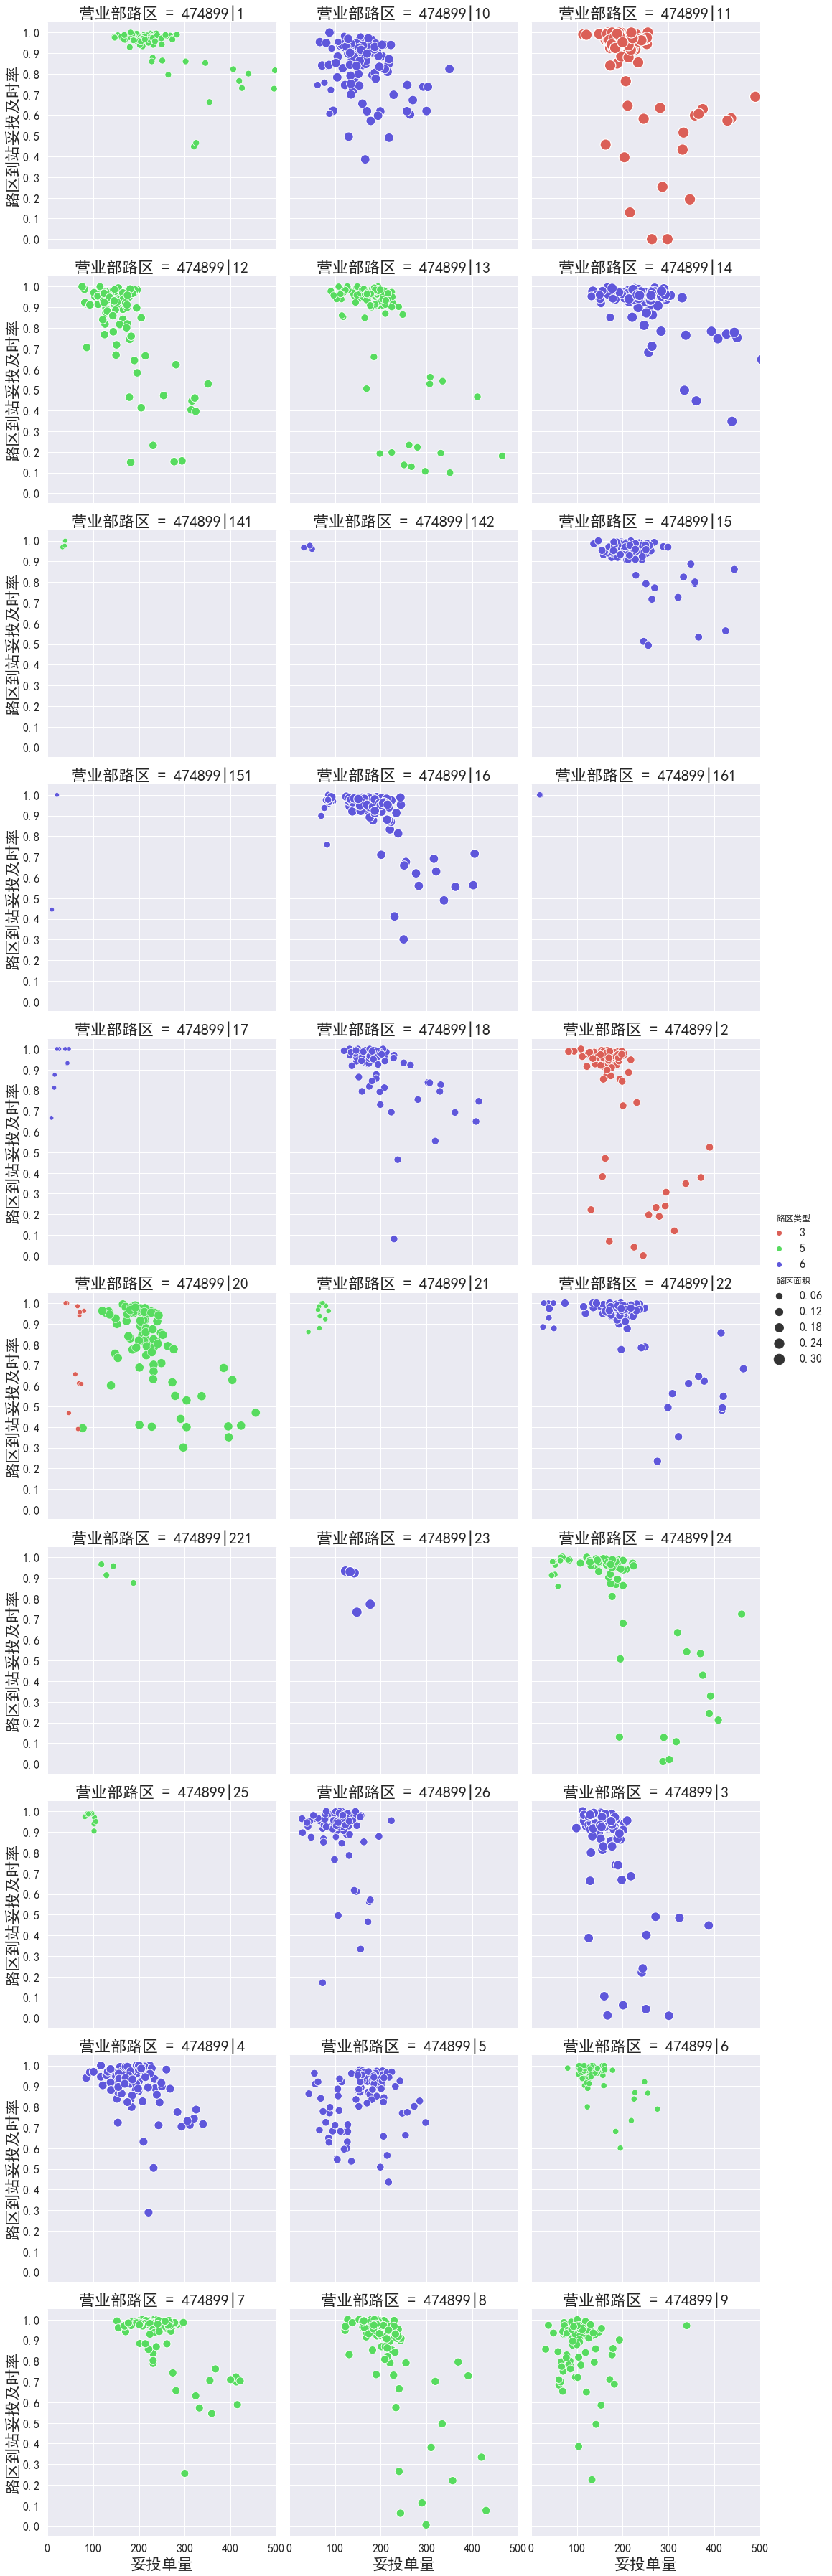

In [12]:
params = {'legend.fontsize':16,
         'axes.labelsize':22,
         'axes.titlesize':28,
         'axes.linewidth': 2,
         'xtick.labelsize':16,
         'ytick.labelsize':16,
          'figure.figsize':(22,18),
         'font.family':'SimHei'}

sns.set_theme(rc = params)#{'figure.figsize':(15,8), 'font.family':'SimHei'})

x = '妥投单量'
y = '路区到站妥投及时率'
col = '营业部路区'
row = '路区名称'
size = '路区面积'
hue = '路区类型'
kind = '路区类型'

df_x = df.sort_values([col])
df_x = df_x[df_x.营业部.isin([474899])]
# df_x = df_x[df_x.路区类型 == '5:商住混合区(偏住)']
df_x = df_x[~df_x.营业部路区.isin(['474899|33', '474899|121', '474899|131'])]

# df_x = df_x[df_x.日期>'2021-10-01']
# df_x[hue] = df_x[hue].astype('str')

title =  x + '与' + y + '的关系'

# heat = sns.color_palette('dark:salmon',as_cmap=True)
heat = sns.color_palette('rocket', as_cmap=True)
ranbow = sns.color_palette("hls", len(df_x[hue].unique()))
sns.set_palette(ranbow) 

# sns.scatterplot(data=df_x, x=x, y=y, hue=hue,alpha=0.85, s=100,palette=['red']*df_x[hue].nunique()).set_title(title)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),title=hue)

col_wrap = np.ceil(np.sqrt(len(df_x[col].unique())))
col_wrap = 3
rel = sns.relplot(data=df_x,x=x,y=y, hue=hue,size=size,sizes=(40, 240),col=col, col_wrap=col_wrap, palette=ranbow)#.fig.

plt.xticks(np.arange(0, 501, 100))
plt.yticks(np.arange(0,1.01,0.1))
# plt.xscale('log')
# plt.yscale('logit')
plt.xlim(-1, 501)
# rel.fig.subplots_adjust(top=0.8)
# rel.fig.suptitle(title, fontsize=25)


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102]),
 [Text(0, 0, '2021-08-05'),
  Text(1, 0, '2021-08-06'),
  Text(2, 0, '2021-08-07'),
  Text(3, 0, '2021-08-08'),
  Text(4, 0, '2021-08-09'),
  Text(5, 0, '2021-08-10'),
  Text(6, 0, '2021-08-11'),
  Text(7, 0, '2021-08-13'),
  Text(8, 0, '2021-08-14'),
  Text(9, 0, '2021-08-16'),
  Text(10, 0, '2021-08-17'),
  Text(11, 0, '2021-08-18'),
  Text(12, 0, '2021-08-19'),
  Text(13, 0, '2021-08-20'),
  Text(14, 0, '2021-08-

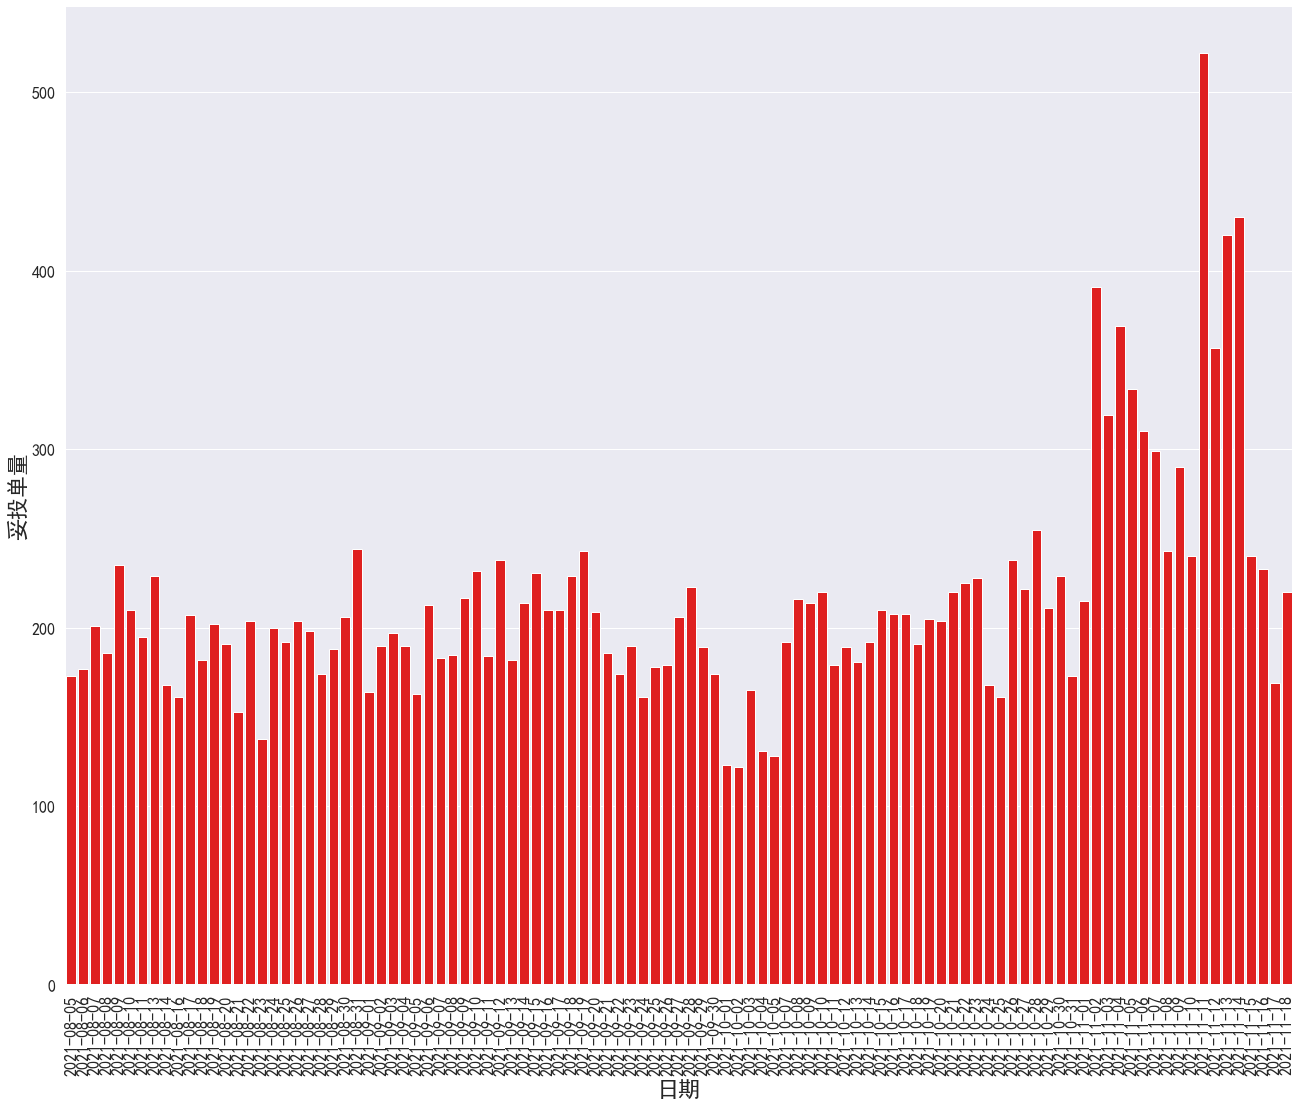

In [158]:
df_ttnl = pd.DataFrame(df.groupby(['营业部路区'])['妥投能力'].mean())
df_ttnl['路区'] = df_ttnl.index.map(lambda x:x[7:])
df_ttnl['营业部'] = df_ttnl.index.map(lambda x:x[:6])
# df_ttnl[df_ttnl['营业部']=='284764']
# sns.barplot(data=df_ttnl[df_ttnl['营业部']=='284764'], x='路区', y='妥投能力', color='blue')
sns.barplot(data=df[df.营业部路区.isin(['474899|8'])], x='日期', y='妥投单量', color='red')
plt.xticks(rotation=90)
